In [2]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(3,20):
        assert counter.get(i,0)==0
        
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [3]:
a = 1e-9
print('{:f}'.format(a))

0.000000


In [4]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

In [5]:
dataset

[{'image': [[1, 1], [1, 1]], 'category': 0},
 {'image': [[0, 0], [0, 0]], 'category': 1}]

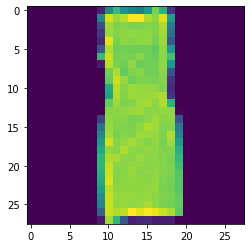

In [6]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1100])

In [8]:
#submission to part 1, you should make this into a .py file

n=len(dataset)
mse=0
gatecount=0

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    q = qiskit.QuantumRegister(3)
    circuit = qiskit.QuantumCircuit(q)
    if image[0][0]==0:
        circuit.rx(np.pi,0)
    return circuit

def decode(histogram):
    if 1 in histogram.keys():
        image=[[0,0],[0,0]]
    else:
        image=[[1,1],[1,1]]
    return image

def run_part1(image):
    #encode image into a circuit
    circuit = encode(image)

    #simulate circuit
    histogram = simulate(circuit)

    #reconstruct the image
    image_re = decode(histogram)

    return circuit,image_re

In [5]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

1.0


In [14]:
def encode(image):
    q = qiskit.QuantumRegister(3)
    circuit = qiskit.QuantumCircuit(q)
    circuit.h([0, 1, 2])
    return circuit

In [15]:
dataset

[{'image': [[1, 1], [1, 1]], 'category': 0},
 {'image': [[0, 0], [0, 0]], 'category': 1}]

In [16]:
simulate(encode(dataset[0]['image']))

{0: 0.12499999999999994,
 1: 0.12499999999999994,
 2: 0.12499999999999994,
 3: 0.12499999999999994,
 4: 0.12499999999999994,
 5: 0.12499999999999994,
 6: 0.12499999999999994,
 7: 0.12499999999999994}

In [17]:
simulate(encode(dataset[1]['image']))

{0: 0.12499999999999994,
 1: 0.12499999999999994,
 2: 0.12499999999999994,
 3: 0.12499999999999994,
 4: 0.12499999999999994,
 5: 0.12499999999999994,
 6: 0.12499999999999994,
 7: 0.12499999999999994}

In [21]:
desired_state

NameError: name 'desired_state' is not defined

In [24]:
28 * 28

784

Raw Image data
[0. 0. 0. 0. 0.]
Image PCA
[-9.39768822e-03 -9.76664193e-05  1.33050374e-02 -2.76735712e-03
  2.54252086e-03]
Image PCA min_ removed
[0.         0.00930002 0.02270273 0.00663033 0.01194021]
(28, 28)
(256,)
1.0
PCA normalized
[0.      0.06119 0.14939 0.04363 0.07857]
Squared PCA
[0.      0.00374 0.02232 0.0019  0.00617]
###########Histogram
[0.         0.00374478 0.0223159  0.00190339 0.0061728 ]
Histogram root
[0.         0.06119461 0.14938508 0.04362791 0.07856718]
Denormalized 
[0.         0.00930002 0.02270273 0.00663033 0.01194021]
Sumar mínimo
[-9.39768822e-03 -9.76664193e-05  1.33050374e-02 -2.76735712e-03
  2.54252086e-03]
(256,)
Reconstructed Image PCA
[-9.39768822e-03 -9.76664193e-05  1.33050374e-02 -2.76735712e-03
  2.54252086e-03]


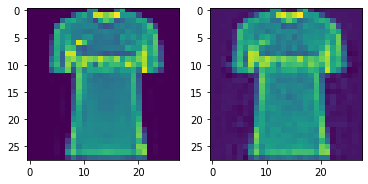

In [13]:
from qiskit import QuantumCircuit
from sklearn.decomposition import PCA

def encode_amplitude(images, image_index, n_qubits, debug=False):
    N_images = len(images)
    # We have 28x28 images as input
    # - we can do amplitude encoding of a normalized amplitude vector that has size of 2 ** n (full power of two)
    # 28 x 28 = 784 doesn't fit into a full power of two, so we use PCA to reduce the dimensionality to fit it 
    # into n_qubits (parametrized)
    
    
    # [apply PCA]
    # Create an instance of PCA
    pca = PCA(n_components=2**n_qubits)

    # Fit PCA on your 784-dimensional data
    data = images.reshape(N_images, 28 * 28)
    pca.fit(data)

    # Apply dimensionality reduction on your data
    data_pca = pca.transform(data)

    image = images[image_index]
    
    if debug:
    
        print("Raw Image data")
        print(data[image_index][:5])
    
    image_pca = data_pca[image_index]
    
    min_ = image_pca.min()
    
    if debug:
        print("Image PCA")
        print(image_pca[:5])

    
    image_pca = image_pca - min_
    
    if debug:
        print("Image PCA min_ removed")
        print(image_pca[:5])
    
    # [normalize]
    def normalize(row):
        #We calculate the squareroot of the sum of the square values of the row
        normalization_factor = np.sqrt(np.sum(row**2)) 
        if normalization_factor == 0.:
            #If the sum is zero we return a 0
            return 0.0
        #Else we divide each value between the sum value above
        row = row / normalization_factor
        return row, normalization_factor
    
    image_pca_normalized, normalization_factor = normalize(image_pca)
    
    if debug:
        print(image.shape)

        print(image_pca_normalized.shape)

        print(np.sum(image_pca_normalized**2))
    
    desired_state = image_pca_normalized
    
    #print(np.round(desired_state, 3))
    if debug:
        print("PCA normalized")
        print(np.round(image_pca_normalized, 5)[:5])

        print("Squared PCA")
        print(np.round(desired_state ** 2, 5)[:5])
    
    ##########
    # Amplitude Encoding
    qc = QuantumCircuit(n_qubits)
    qc.initialize(desired_state)
    qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()

    ##########
    
    decoder_params = dict(
        pca=pca,
        min_=min_,
        normalization_factor=normalization_factor,
        n_qubits=n_qubits,
        image=image
    )
    
    return qc_decomposed, decoder_params

def decode_amplitude(histogram, normalization_factor, min_, pca, n_qubits, image, debug=False):
    
    histogram_array = np.zeros(2 ** n_qubits)
    
    for i in range(2 ** n_qubits):
        histogram_array[i] = histogram.get(i, 0)
    
    if debug:
        print("###########Histogram")

        print(histogram_array[:5])
    
    root = np.sqrt(histogram_array)
    
    if debug:
        print("Histogram root")
        print(root[:5])
    
    root = root * normalization_factor
    
    if debug:
        print("Denormalized ")
        print(root[:5])
    
    root = root + min_
    if debug:
        print("Sumar mínimo")
        print(root[:5])
    
        print(root.shape)
    
        print("Reconstructed Image PCA")
        print(root[:5])
    
    reconstruction = pca.inverse_transform([root])
    
    #print(reconstruction)
    
    reconstructed_image = reconstruction[0].reshape(28, 28)
    
    if debug:
    
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

        ax1.imshow(image)
    
        ax2.imshow(reconstructed_image)
    
        plt.show()
    
    return reconstructed_image
    
qc, decoder_params = encode_amplitude(images, 250, 8, debug=True)    

histogram = simulate(qc)


image = decode_amplitude(histogram, **decoder_params, debug=True)



In [14]:
count_gates(qc)

Counter({1: 135, 2: 254})

In [ ]:
import tqdm

def run_part1(images, image_index, n_qubits=8):
    #encode image into a circuit
    circuit, decoder_params = encode_amplitude(images, image_index, n_qubits=n_qubits)

    #simulate circuit
    histogram = simulate(circuit)

    #reconstruct the image
    image_re = decode_amplitude(histogram, **decoder_params)

    return circuit,image_re

#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for i, data in tqdm.tqdm(enumerate(images)):
    #encode image into circuit
    circuit, image_re =run_part1(images, i, n_qubits=8)
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    #print(images[i].shape)
    #print(image_re.shape)
    mse+=image_mse(images[i],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

1982it [2:45:41, 25.61s/it]

In [87]:
import pandas as pd
pd.DataFrame(labels, columns=["label"]).query("label==True")

,label
0,True
1,True
2,True
3,True
4,True
...,...
495,True
496,True
497,True
498,True


In [ ]:
"""
Shirt vs no shirt
no shirt pueden ser distintos
"""

In [77]:
2 ** 10

1024

In [98]:
qc.decompose().decompose().decompose().decompose().draw()

»
q_0: ─|0>─────────────────────────────────────────────────────────────────────»
                                                                              »
q_1: ─|0>─────────────────────────────────────────────────────────────────────»
                                                                              »
q_2: ─|0>─────────────────────────────────────────────────────────────────────»
                                                                              »
q_3: ─|0>─────────────────────────────────────────────────────────────────────»
                                                                              »
q_4: ─|0>─────────────────────────────────────────────────────────────────────»
                                                                              »
q_5: ─|0>─────────────────────────────────────────────────────────────────────»
          ┌───────────────────────┐┌───┐┌───────────────────────────────┐┌───┐»
q_6: ─|0>─┤ multiplex1_reverse_dg ├┤ X ├┤ multiplex1_reverse_reverse_dg ├┤ X ├»
          └─────┬────────────┬────┘└─┬─┘└───────────────────────────────┘└─┬─┘»
q_7: ─|0>───────┤ Ry(1.5738) ├───────■─────────────────────────────────────■──»
                └────────────┘                                                »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_4: ──────────────────────────────────────────────────────────────────────»
«     ┌────────────────────────┐┌───┐┌────────────────────────────────┐┌───┐»
«q_5: ┤0                       ├┤ X ├┤0                               ├┤ X ├»
«     │  multiplex2_reverse_dg │└─┬─┘│  multiplex2_reverse_reverse_dg │└─┬─┘»
«q_6: ┤1                       ├──┼──┤1                               ├──┼──»
«     └────────────────────────┘  │  └────────────────────────────────┘  │  »
«q_7: ────────────────────────────■──────────────────────────────────────■──»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ──────────────────────────────────────────────────────────────────────»
«     ┌────────────────────────┐┌───┐┌────────────────────────────────┐┌───┐»
«q_4: ┤0                       ├┤ X ├┤0                               ├┤ X ├»
«     │                        │└─┬─┘│                                │└─┬─┘»
«q_5: ┤1 multiplex3_reverse_dg ├──┼──┤1 multiplex3_reverse_reverse_dg ├──┼──»
«     │                        │  │  │                                │  │  »
«q_6: ┤2                       ├──┼──┤2                               ├──┼──»
«     └────────────────────────┘  │  └────────────────────────────────┘  │  »
«q_7: ────────────────────────────■──────────────────────────────────────■──»
«                                                                           »
«                                                                 

In [110]:
qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()
count_gates(qc_decomposed)

Counter({2: 254, 1: 135})


AssertionError: 

In [64]:
histogram.keys()

dict_keys([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22